# Part 1: Skin Cancer Detection with EfficientNetV2



In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

## 1.1 Download the dataset from Skin Cancer: Malignant vs. Benign 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir='/content/drive/MyDrive/Colab Notebooks/dataset/train'
Labels = ['Benign', 'Malignant']
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Benign
1 Malignant


In [5]:
print('Number of classes:',len(Labels))

Number of classes: 2


## 1.2 Define your custom CNN model based on the pretrained EfficientNetV2 model


In [6]:
module_selection = ("imagenet/efficientnet_v2_imagenet21k_b0", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

## 1.3 Load train test validation data

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      #rescale = 1./255,
      #rotation_range=40,
      #horizontal_flip=True,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #fill_mode='nearest',
      #validation_split=0.3)
      featurewise_center=True,
      samplewise_center=True,
      featurewise_std_normalization=True,
      samplewise_std_normalization=True,
      zca_whitening=True,
      zca_epsilon=1e-06,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=(0,0.5),
      shear_range=0.2,
      zoom_range=0.2,
      channel_shift_range=0.2,
      fill_mode='nearest',
      cval=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      rescale=1./255,
      preprocessing_function=None,
      data_format=None,
      validation_split=0.2,
      interpolation_order=1,
      dtype=None)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 2110 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


## 1.4 Apply transfer learning and fine-tuning (Transfer learning & fine-tuning (keras.io)) of top layers of EfficientNetv2’s feature extractor.


In [8]:
effnetv2_model = tf.keras.applications.EfficientNetV2B0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# Wrap the model with hub.KerasLayer
feature_extractor = hub.KerasLayer(effnetv2_model, input_shape=IMAGE_SIZE + (3,), output_shape=[FV_SIZE])

do_fine_tuning = True

if do_fine_tuning:
    feature_extractor.trainable = True
    for layer in effnetv2_model.layers[-30:]:
        layer.trainable = True
else:
    feature_extractor.trainable = False

print("Building model with", effnetv2_model)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Building model with <keras.src.engine.functional.Functional object at 0x7a954253a770>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 7, 7, 1280)        5919312   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 5921874 (22.59 MB)
Trainable params: 5861266 (22.36 MB)
Non-trainable params: 60608 (236.

## 1.5 Add to your model these regularization methods weight decay (How to Use Weight Decay


In [9]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

##  1.6 train the model

In [10]:
EPOCHS=200
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,callbacks=[callback])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/200
131/131 [==============================] - 435s 3s/step - loss: 0.4568 - accuracy: 0.7803 - val_loss: 0.8154 - val_accuracy: 0.6133
Epoch 2/200
131/131 [==============================] - 62s 475ms/step - loss: 0.3934 - accuracy: 0.8152 - val_loss: 0.5273 - val_accuracy: 0.7285
Epoch 3/200
131/131 [==============================] - 61s 469ms/step - loss: 0.3838 - accuracy: 0.8209 - val_loss: 0.7289 - val_accuracy: 0.4316
Epoch 4/200
131/131 [==============================] - 61s 461ms/step - loss: 0.3567 - accuracy: 0.8281 - val_loss: 0.5175 - val_accuracy: 0.7188
Epoch 5/200
131/131 [==============================] - 71s 542ms/step - loss: 0.3200 - accuracy: 0.8582 - val_loss: 0.4181 - val_accuracy: 0.8066
Epoch 6/200
131/131 [==============================] - 71s 543ms/step - loss: 0.3057 - accuracy: 0.8572 - val_loss: 0.9533 - val_accuracy: 0.5762
Epoch 7/200
131/131 [==============================] - 64s 488ms/step - loss: 0.3066 - accuracy: 0.8696 - val_loss: 0.6758 - v

## 1.7 Test and evaluate your model.


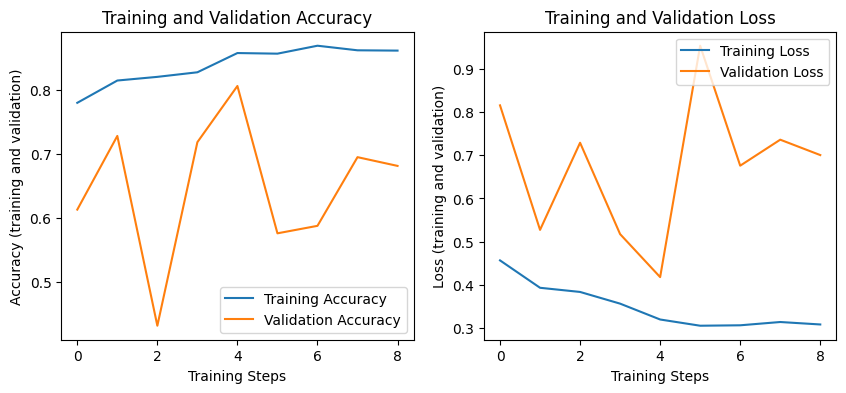

In [11]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [12]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

33/33 [==============================] - 14s 343ms/step


Confusion Matrix


<Axes: >

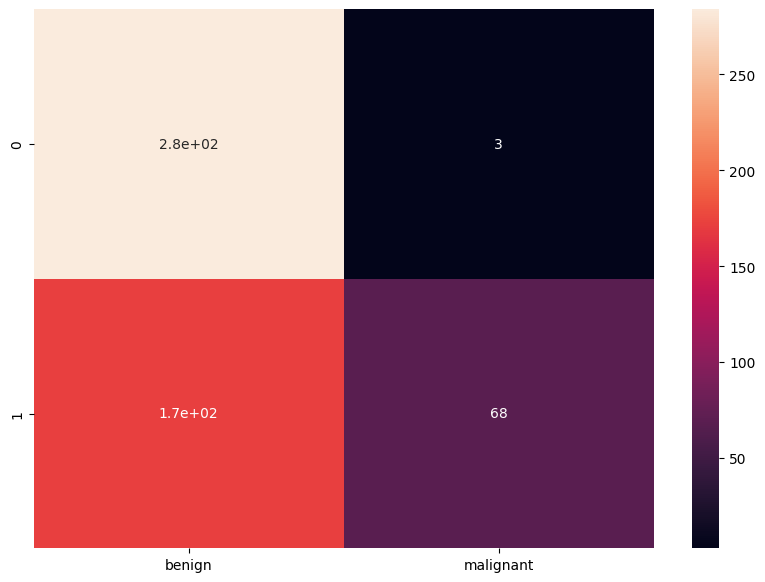

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred_class)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

## 1.8 Save your custom CNN TensorFlow model and convert it to TFlite


In [16]:
import time
t = time.time()

export_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/content/drive/MyDrive/Colab Notebooks/saved_models/1701004854'

In [17]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: benign, file: benign/1085.jpg
1/1 [==============================] - 1s 1s/step
PREDICTED: class: Benign, confidence: 0.753289


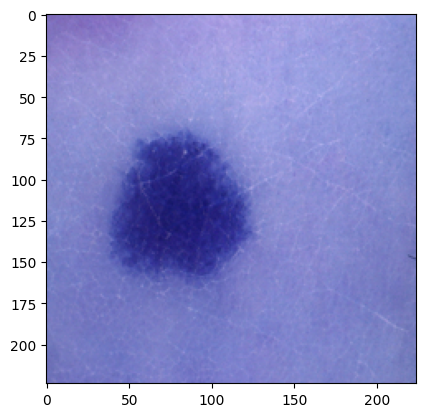

<Figure size 640x480 with 0 Axes>

SOURCE: class: benign, file: benign/1001.jpg
1/1 [==============================] - 0s 38ms/step
PREDICTED: class: Benign, confidence: 0.766035


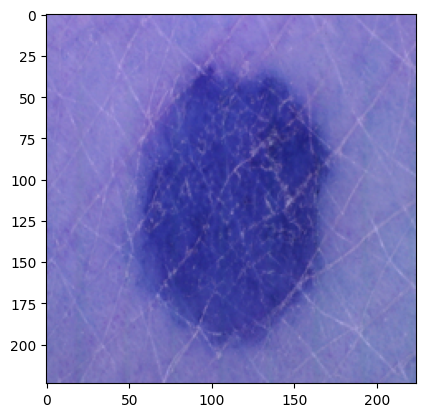

In [18]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [26]:
#convert the model to TFLite
!mkdir "/content/drive/MyDrive/Colab Notebooks/tflite_models"

TFLITE_MODEL = "/content/drive/MyDrive/Colab Notebooks/tflite_models/model.tflite"

run_model = tf.function(lambda x : reloaded(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

23497472